In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import os

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
def load_data(fpath='data/SP1.csv'):
    if os.path.isfile(fpath):
        return pd.read_csv(fpath)
    return None

In [4]:
df = load_data()
df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,SP1,16/08/2019,20:00,Ath Bilbao,Barcelona,1,0,H,0,0,...,1.97,0.75,1.93,2.00,1.91,2.01,2.02,2.03,1.91,1.98
1,SP1,17/08/2019,16:00,Celta,Real Madrid,1,3,A,0,1,...,2.63,1.00,1.82,1.97,1.85,2.07,2.00,2.20,1.82,2.06
2,SP1,17/08/2019,18:00,Valencia,Sociedad,1,1,D,0,0,...,1.82,-0.75,1.94,1.99,1.92,2.00,1.96,2.12,1.89,2.00
3,SP1,17/08/2019,19:00,Mallorca,Eibar,2,1,H,1,0,...,1.66,0.00,2.11,1.82,2.09,1.83,2.12,1.88,2.07,1.83
4,SP1,17/08/2019,20:00,Leganes,Osasuna,0,1,A,0,0,...,1.46,-0.50,1.89,2.04,1.90,2.01,1.95,2.06,1.90,1.99


In [5]:
def prepare_data(df: pd.DataFrame):
    df = df.loc[:, ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    df.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'}, inplace=True)
    team_categorical = pd.Categorical(df.HomeTeam)
    df['HomeTeamId'] = team_categorical.codes
    df['AwayTeamId'] = pd.Categorical(df.AwayTeam, dtype=team_categorical.dtype).codes
    return df

In [6]:
df = prepare_data(df)
df.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,HomeTeamId,AwayTeamId
0,Ath Bilbao,Barcelona,1,0,1,3
1,Celta,Real Madrid,1,3,5,14
2,Valencia,Sociedad,1,1,17,16
3,Mallorca,Eibar,2,1,12,6
4,Leganes,Osasuna,0,1,10,13


In [7]:
n_teams = len(df.HomeTeam.unique())
print(f'Total teams = {n_teams}')

Total teams = 20


## Model 1

No home advantage. 

attack_group_mean ~ Normal(0, 1)  
attack_group_sd ~ HalfCauchy(1)  
attack_team<sub>i</sub> ~ Normal(attack_group_mean, attack_group_sd)  

defense_group_mean ~ Normal(0, 1)  
defense_group_sd ~ HalfCauchy(1)  
defense_team<sub>i</sub> ~ Normal(defense_group_mean, defense_group_sd)  

log(home_rate<sub>i, j</sub>) = attack_team<sub>i</sub> - defense_team<sub>j</sub>  
home_goals<sub>i, j</sub> ~ Poisson(home_rate<sub>i, j</sub>)<br>
log(away_rate<sub>i, j</sub>) = attack_team<sub>j</sub> - defense_team<sub>i</sub>  
away_goals<sub>i, j</sub> ~ Poisson(away_rate<sub>i, j</sub>)

In [8]:
with pm.Model() as model_1:
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=1)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team = pm.Normal('attack_team', mu=attack_group_mean, sd=attack_group_sd, shape=n_teams)
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=1)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team = pm.Normal('defense_team', mu=defense_group_mean, sd=defense_group_sd, shape=n_teams)
    
    home_rate = pm.math.exp(attack_team[df.HomeTeamId] - defense_team[df.AwayTeamId])
    away_rate = pm.math.exp(attack_team[df.AwayTeamId] - defense_team[df.HomeTeamId])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    trace_1 = pm.sample(1000, tune=1000)

/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Usi

/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matp

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f41db579c10>,
      dtype=object)

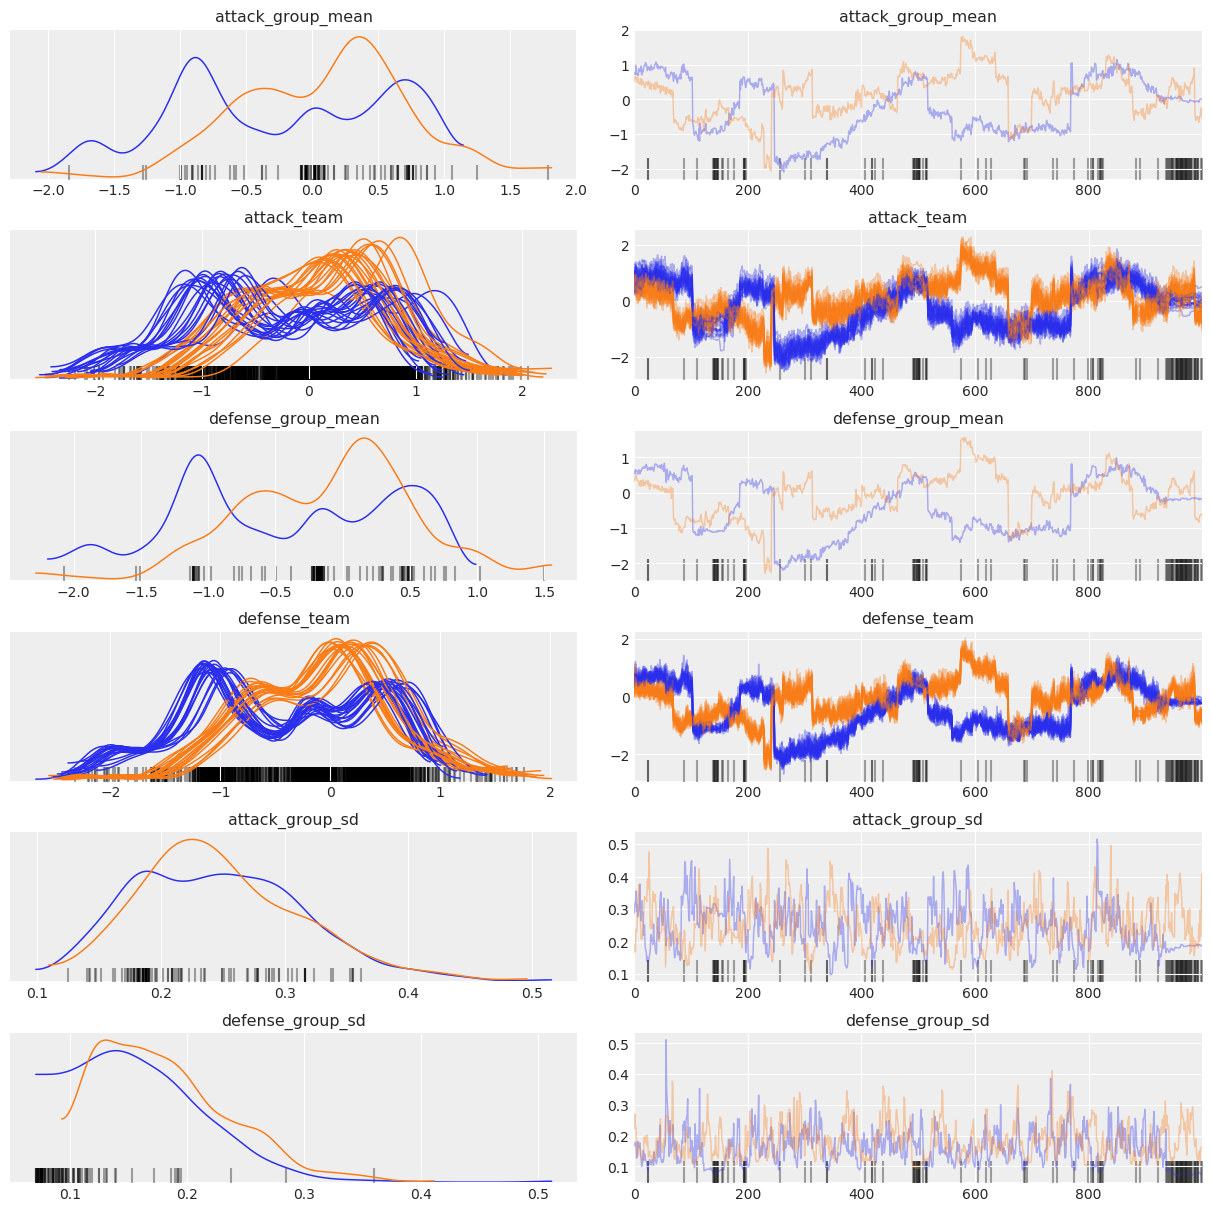

In [9]:
az.plot_trace(trace_1, compact=True)

* Too many divergences in model 1.
* Chains do not converge and mix properly.
* R hat statistic too large

Need to reparametrize the model

## Model 1 non-centered parametrization

In [16]:
with pm.Model() as model_1_nc:
    attack_group_mean = pm.Normal('attack_group_mean', mu=0, sd=1)
    attack_group_sd = pm.HalfCauchy('attack_group_sd', 1)
    attack_team_z = pm.Normal('attack_team_z', mu=0, sd=1, shape=n_teams)
    attack_team = pm.Deterministic('attack_team', attack_group_mean + attack_group_sd * attack_team_z)
    
    defense_group_mean = pm.Normal('defense_group_mean', mu=0, sd=1)
    defense_group_sd = pm.HalfCauchy('defense_group_sd', 1)
    defense_team_z = pm.Normal('defense_team_z', mu=0, sd=1, shape=n_teams)
    defense_team = pm.Deterministic('defense_team', defense_group_mean + defense_group_sd * defense_team_z)
    
    home_rate = pm.math.exp(attack_team[df.HomeTeamId] - defense_team[df.AwayTeamId])
    away_rate = pm.math.exp(attack_team[df.AwayTeamId] - defense_team[df.HomeTeamId])
    
    home_goals = pm.Poisson('home_goals', mu=home_rate, observed=df.HomeGoals)
    away_goals = pm.Poisson('away_goals', mu=away_rate, observed=df.AwayGoals)
    trace_1_nc = pm.sample(1000, tune=1000)

/home/sagar/miniconda3/envs/ml/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [defense_team_z, defense_group_sd, defense_group_mean, attack_team_z, attack_group_sd, attack_group_mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [01:22<00:00, 48.46draws/s]


az.plot_trace(trace_1_nc, compact=True)

Text(0, 0.5, 'Density')

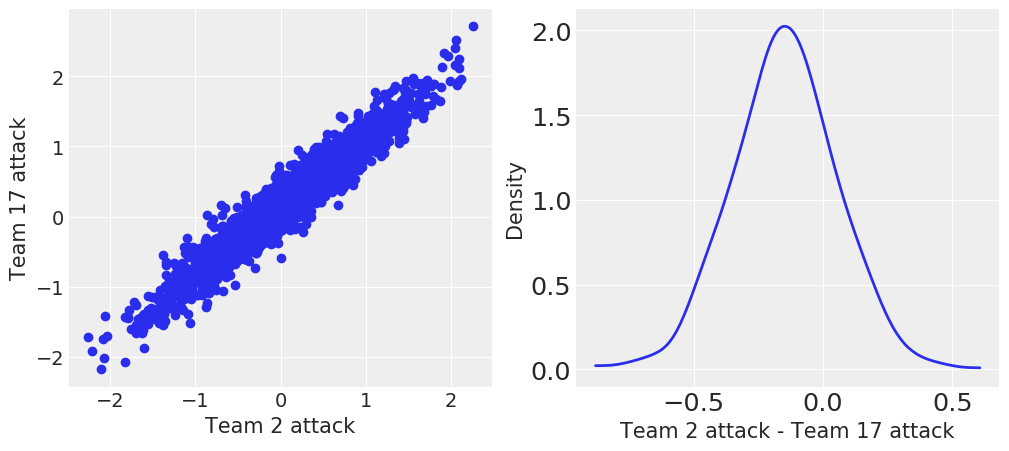

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(trace_1_nc['attack_team'][:, 2], trace_1_nc['attack_team'][:, 17], 'o')
axs[0].set_xlabel('Team 2 attack')
axs[0].set_ylabel('Team 17 attack')

az.plot_dist(trace_1_nc['attack_team'][:, 2] - trace_1_nc['attack_team'][:, 17], ax=axs[1])
axs[1].set_xlabel('Team 2 attack - Team 17 attack')
axs[1].set_ylabel('Density')

* Too much variance in parameter estimates.
* Model is unidentifiable. Adding any constant k to all the attack and defense parameters will lead to the same predictions
* Need to add some more constraints.